# Word2Vec Distributions

/var/folders/v9/gjq5vjbs1qv8bm8yhcn91xb80000gn/T/ipykernel_287/3154583868.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(vector, kde=False, rug=True)


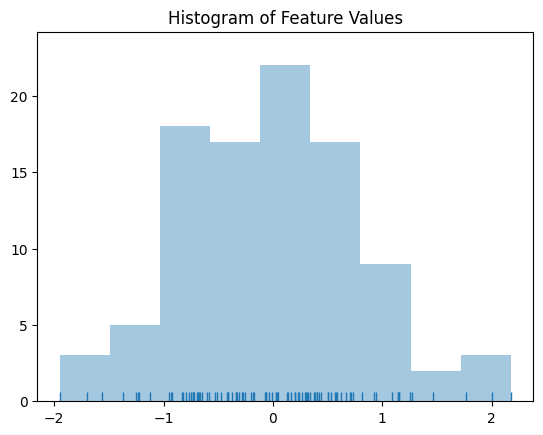

In [2]:
%matplotlib inline
import spacy
import re

import seaborn as sns
import numpy as np

nlp = spacy.load("en_core_web_sm")
vector = nlp(u'banana').vector

ax = sns.distplot(vector, kde=False, rug=True)
t = ax.set_title('Histogram of Feature Values')



## Optimization Techniques

### Subsampling

What do we do with highly frequent words like `the` or `of`? We don't gain a ton of meaning from training on these words, and they become computationally expensive since they appear so frequently:

![alt text](https://raw.githubusercontent.com/ychennay/dso-560-nlp-text-analytics/main/images/subsampling.png "http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/")
In the image above, $z(w_i)$ is the frequency of that particular word divided by the total number of words in the entire corpus. For instance, if a corpus of text has 50 words, and the word `dog` appears 3 times, $z(w_{dog}) = 0.06$.

In [ ]:
import numpy as np
# write subsampling function
def subsample(z):
    return ((z * 1000) ** 0.5 + 1) * (0.001 / z)

# plot this function:
import matplotlib.pyplot as plt

Z = list(np.linspace(0,1,100))
probability_of_keeping = list(map( lambda z: subsample(z), Z))

plt.scatter(Z, probability_of_keeping)
plt.xlabel("Frequency word appears in corpus")
plt.ylabel("Probability of keeping")
plt.show()

## Limitations of Word Embeddings

#### How to handle **Out Of Vocabulary (OOV)** words?
Although **word2vec** and **FastText** include a significant vocabulary size, there will inevitably be words that are not included. For instance, if you are analyzing text conversations using word embeddings pretrained on Wikipedia text (which typically has more formal vocabulary than everyday language), how will you account for the following words?

- DM
- ROFLMAO
- bae
- 😃
- #10YearChallenge
- wut

#### Potential solution: use word embeddings if they are available, and otherwise initialize the weights to random.

```python
import numpy as np
def vectorize_word(input_word: str, D=50):
    """
    D: an integer that represents the length (dimensionality of the word embeddings)
    word_embeddings: A dictionary object with the string word as the key, and the embedding vector of 
    length D as the values.
    For instance, word_embeddings["cat"] will return [2.3, 4.5, 6.1, -2.2, ...]
    """
    if input_word in word_embeddings.keys():
        return word_embeddings[input_word]
    else:
        return np.random.rand(D)
```

##### Should we update the word embedding matrices during the model training step?
- Ideally, you'd only want to be able to update the specific weights that were randomly initialized (since the rest of the weights are by definition pre-trained and are already pretty good). However, most deep learning libraries do not allow you to easily select which specific weight elements to apply backpropagation to- you either update all weights or you update none. In practice, most data scientists will "freeze" the word embedding layer:

In Keras:
```python
word_embedding_layer.trainable = False # by default, trainable is set to true in Keras
```
In Tensorflow:
```python
import tensorflow as tf
N = 300 # number of words
D = 50 # of dimensions in embeddings
initial_word_embeddings = [0, 1, 2, 3, 4, 5, 6, 7]
tensor = tf.constant(initial_word_embeddings, shape=[N, D])
```

- Ambiguity around **Domain-specific words**: using a generic pre-trained word embedding will not capture the semantic meaning of the word **sack** when it is used in the context of American football:
![sack](https://raw.githubusercontent.com/ychennay/dso-560-nlp-text-analytics/main/images/football-bag-sack-diff.png)

# Gensim

In [4]:
# from https://radimrehurek.com/gensim/models/word2vec.html
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")
model = Word2Vec(common_texts, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [5]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [6]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
             ['this', 'is', 'the', 'second', 'sentence'],
             ['yet', 'another', 'sentence'],
             ['one', 'more', 'sentence'],
             ['and', 'the', 'final', 'sentence'],
            ["first", "and", "second", "sentence"]]
# train model
# you can also specify an alpha, which is a hyperparameter learning rate
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary1
model.wv.key_to_index
model.wv.get_vector("sentence")


Word2Vec<vocab=14, vector_size=100, alpha=0.025>


array([-5.3613470e-04,  2.3713129e-04,  5.1058987e-03,  9.0121645e-03,
       -9.3048755e-03, -7.1178679e-03,  6.4615863e-03,  8.9742010e-03,
       -5.0173230e-03, -3.7642212e-03,  7.3823351e-03, -1.5340967e-03,
       -4.5365901e-03,  6.5550972e-03, -4.8604906e-03, -1.8166588e-03,
        2.8769472e-03,  9.9250535e-04, -8.2884440e-03, -9.4515411e-03,
        7.3134978e-03,  5.0723492e-03,  6.7602862e-03,  7.6203729e-04,
        6.3516032e-03, -3.4052967e-03, -9.4666512e-04,  5.7692323e-03,
       -7.5236904e-03, -3.9367126e-03, -7.5138286e-03, -9.3064696e-04,
        9.5404182e-03, -7.3211812e-03, -2.3341118e-03, -1.9382533e-03,
        8.0786739e-03, -5.9320745e-03,  4.4811048e-05, -4.7555189e-03,
       -9.6055325e-03,  5.0082025e-03, -8.7615345e-03, -4.3924255e-03,
       -3.4532673e-05, -2.9693675e-04, -7.6633105e-03,  9.6167298e-03,
        4.9833693e-03,  9.2346733e-03, -8.1605939e-03,  4.4963211e-03,
       -4.1372753e-03,  8.2342041e-04,  8.5003115e-03, -4.4622524e-03,
      

## Training Your Own Word2Vec Embeddings Using Gensim

In [7]:
reviews = open("../datasets/good_amazon_toy_reviews.txt").readlines() + open("../datasets/poor_amazon_toy_reviews.txt").readlines()

In [8]:
from nltk import word_tokenize

In [9]:
docs = [word_tokenize(review) for review in reviews]

In [10]:
model = Word2Vec(docs, min_count=5)

In [11]:
model.wv.most_similar("amazon")

[('Amazon', 0.8515133261680603),
 ('sale', 0.7785695195198059),
 ('here', 0.6191052794456482),
 ('Amazon.com', 0.5998008847236633),
 ('Thursday', 0.5991731882095337),
 ('ebay', 0.5956100225448608),
 ('whim', 0.5914636850357056),
 ('Friday', 0.5784347057342529),
 ('market', 0.5771557688713074),
 ('eBay', 0.5761690735816956)]

## Using GoogleNews word2vec vectors

You can download the entire dataset for word2vec trained via negative sampling [here](https://code.google.com/archive/p/word2vec/).

In [ ]:
## WARNING: RUNNING THIS CELL WILL DOWNLOAD A 1GB dataset to your computer
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
vec_king = wv['homework']

In [ ]:
# load in the entire Google News word embedding vectors
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

# word analogies
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

In [ ]:
# get the most similar words for a target word
model.most_similar("cappucino")

# FastText

A major problem with `word2vec` and other traditional word embedding strategies is how to deal with out of bag (OOB) or out of vocabulary (OOV) words.

The vector embedding for the word `photosynthesis` will be the average of `pho`, `phot`, `photo`, etc.

This allow FastText to embed many words that are not traditionally in the trained vocabulary (`photogenic` may be OOB, but `photo` will be available).

### When to use?

- traditionally, each individual word is trained onto a new word embedding
- in many languages (including English), many words are morphologically derivative from each other. 
- use case when your corpus contains high-value, morphologically diverse, rare words (`photosynthesis`, `transcendentalism`)
- may also be effective when your text contains lots of misspellings or abbreviations (ie. SMS, digital conversations)

#### How is it Different Than word2vec?

- word2vec considers only the entire word, whereas `fasttext` will consider each suffix n-gram.

As [Radim Hurek](https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html) says:

> The main principle behind fastText is that the morphological structure of a word carries important information about the meaning of the word. Such structure is not taken into account by traditional word embeddings like Word2Vec, which train a unique word embedding for every individual word. This is especially significant for morphologically rich languages (German, Turkish) in which a single word can have a large number of morphological forms, each of which might occur rarely, thus making it hard to train good word embeddings.


In [ ]:
import fasttext

model = fasttext.train_unsupervised(
    '../datasets/good_amazon_toy_reviews.txt', model='skipgram', lr=0.05, dim=100, ws=5, epoch=5)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(model["adore"].reshape(1,-1), model["love"].reshape(1,-1))

### FastText Hyperparameters (From [Tutorial Notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb))
- **model**: Training architecture. Allowed values: `cbow`, `skipgram` (Default `cbow`)
- **size**: Size of embeddings to be learnt (Default 100)
- **alpha**: Initial learning rate (Default 0.025)
- **window**: Context window size (Default 5)
- **min_count**: Ignore words with number of occurrences below this (Default 5)
- **loss**: Training objective. Allowed values: `ns`, `hs`, `softmax` (Default `ns`)
- **sample**: Threshold for downsampling higher-frequency words (Default 0.001)
- **negative**: Number of negative words to sample, for `ns` (Default 5)
- **iter**: Number of epochs (Default 5)
- **sorted_vocab**: Sort vocab by descending frequency (Default 1)
- **threads**: Number of threads to use (Default 12)

Hyperparameters unique to `fasttext`:
- **min_n**: min length of char ngrams (Default 3)
- **max_n**: max length of char ngrams (Default 6)
- **bucket**: number of buckets used for hashing ngrams (Default 2000000)

## Gensim Implementation of FastText

In [11]:
from gensim.models import FastText
from gensim.test.utils import common_texts

In [6]:
import pandas as pd
from nltk import word_tokenize
text = list(pd.read_csv("../datasets/bbc-text.csv")["text"].values)

new_text = [word_tokenize(story) for story in text]

#### Train a New FastText Model Using the Corpus Available

You can check the parameters available for you to tune [here](https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText.train).

In [14]:
model = FastText(vector_size=40, window=3, min_count=1)  # change the size of the windows
model.build_vocab(new_text)
model.train(new_text, total_examples=len(new_text), epochs=10)

(7053763, 9176110)

In [16]:
# get corpus total count
model.corpus_count

2225

In [21]:
# get word vector for dog
model.wv["dog"]

array([-3.2222363e-01, -2.2078693e+00,  3.5745579e-01,  6.5984428e-01,
       -2.0824301e+00, -1.5883364e-01,  7.4407870e-01, -2.9683098e-01,
       -1.4233255e-01,  2.2058125e-01, -3.3079988e-01, -2.2909251e-01,
        6.1040205e-01,  9.1151112e-01, -1.4807616e+00, -1.0192211e+00,
        1.2085850e+00,  4.1515335e-01, -1.4587786e+00,  6.5934646e-01,
       -2.9038453e-01, -1.4285205e-01, -1.5967873e-01,  4.7649127e-01,
       -9.2041689e-01,  8.4571254e-01,  8.7594099e-02,  7.1397549e-01,
        1.3489476e+00, -1.1265091e+00,  3.8475925e-01, -5.4505509e-01,
       -1.4048903e-01,  1.2123585e-04,  7.0672899e-01,  1.4613642e+00,
       -6.0756701e-01,  5.5079877e-01,  1.3566753e+00,  2.4346066e-01],
      dtype=float32)

In [23]:
# get length of word embeddings
len(model.wv["king"])

40

In [28]:
print(model.wv.most_similar("france"))
print("\n")
print(model.wv.most_similar("aquaman"))
print("\n")
print(model.wv.most_similar("transc"))

[('francesca', 0.9700016975402832), ('francesco', 0.9565298557281494), ('francique', 0.9212310910224915), ('franchisee', 0.9076738357543945), ('franck', 0.9072319269180298), ('melancholia', 0.9044543504714966), ('northumberland', 0.9014002680778503), ('icelandic', 0.9005484580993652), ('francs', 0.9004991054534912), ('holland', 0.898938000202179)]


[('56-man', 0.9893273115158081), ('22-man', 0.9890055656433105), ('44-man', 0.9877821803092957), ('pitman', 0.9865984320640564), ('25-man', 0.9860122799873352), ('13-man', 0.9850900173187256), ('15-man', 0.9841371178627014), ('kidman', 0.9826959371566772), ('30-man', 0.9824084639549255), ('ryman', 0.9820998311042786)]


[('transcript', 0.9709033966064453), ('transcripts', 0.9535253643989563), ('transmit', 0.9499515295028687), ('transform', 0.948307991027832), ('transsexual', 0.9453391432762146), ('translate', 0.9408653974533081), ('traffic', 0.9380313158035278), ('tracy', 0.9353316426277161), ('transforms', 0.9351500868797302), ('transit', 

## Doc2Vec

### Distributed Memory Version of Paragraph Vector (PV-DM)
![](https://raw.githubusercontent.com/ychennay/dso-560-nlp-text-analytics/main/images/doc2vec.png)

### Distributed Bag of Words of Paragraph Vector (PV-DBOW)
![](https://raw.githubusercontent.com/ychennay/dso-560-nlp-text-analytics/main/images/doc2vec2.png)
[A Gentle Introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)

In [34]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews)]
model = Doc2Vec(documents, vector_size=50, window=4, min_count=2, workers=4)

In [40]:
doc1_vector = model.infer_vector(["The", "toy", "was", "broken", "quickly"]).reshape(1, -1)
doc2_vector = model.infer_vector(["It", "broke", "fast"]).reshape(1, -1)
doc3_vector = model.infer_vector(["I ate lunch late"]).reshape(1,-1)
doc4_vector = model.infer_vector(["It", "was", "crappy", "quality"]).reshape(1, -1)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
cosine_similarity(doc1_vector, doc2_vector)

array([[-0.01620534]], dtype=float32)

In [42]:
cosine_similarity(doc1_vector, doc3_vector)

array([[-0.4734929]], dtype=float32)

In [43]:
cosine_similarity(doc2_vector, doc3_vector)

array([[0.23254903]], dtype=float32)

In [44]:
cosine_similarity(doc3_vector, doc4_vector)

array([[0.11511255]], dtype=float32)